## 2.1 Import Python Libraries

In [1]:
import boto3, cv2, time
import base64
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image

from sagemaker.pytorch import PyTorchPredictor
from sagemaker.deserializers import JSONDeserializer

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


## 2.2 Check if Endpoint creation is successful and create the predictor

In [2]:
sm_client = boto3.client(service_name="sagemaker")

# Restore the endpoint name stored in the 2_DeployEndpoint.ipynb notebook
ENDPOINT_NAME= "yolov8-images-serverless-endpoint"
print(f'Endpoint Name: {ENDPOINT_NAME}')

endpoint_created = False
while True:
    response = sm_client.list_endpoints()
    for ep in response['Endpoints']:
        print(f"Endpoint Status = {ep['EndpointStatus']}")
        if ep['EndpointName']==ENDPOINT_NAME and ep['EndpointStatus']=='InService':
            endpoint_created = True
            break
    if endpoint_created:
        break
    time.sleep(5)

Endpoint Name: yolov8-images-serverless-endpoint
Endpoint Status = InService


In [3]:
predictor = PyTorchPredictor(endpoint_name=ENDPOINT_NAME,
                             deserializer=JSONDeserializer())

## 2.3 Run Inference and Generate output results

In [4]:
infer_start_time = time.time()

orig_image = cv2.imread('./data/d3f34243-a7166713.jpg')

payload = cv2.imencode('.jpg', orig_image)[1].tobytes()
result = predictor.predict(payload)

output_image = result["image"]

infer_end_time = time.time()

print(f"Inference Time = {infer_end_time - infer_start_time:0.4f} seconds")



Inference Time = 1.4376 seconds


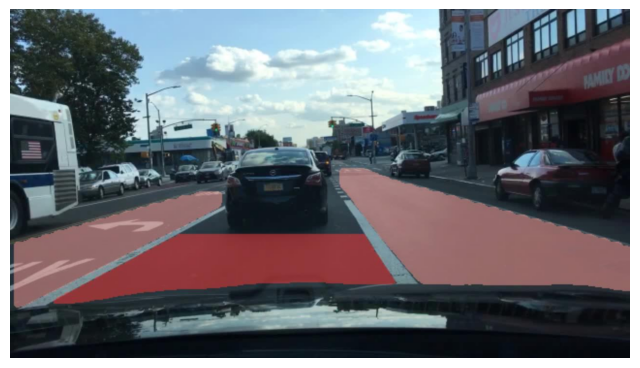

In [5]:
# Convert the base64 string to bytes
image_bytes = base64.b64decode(output_image)

# Load the image from the bytes using PIL
image = Image.open(BytesIO(image_bytes))

# Display the image using Matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis('off')
plt.show()


## 2.4 Cleanup by removing Endpoint, Endpoint Config and Model

In [ ]:
response = sm_client.describe_endpoint_config(EndpointConfigName=ENDPOINT_NAME)
print(response)
endpoint_config_name = response['EndpointConfigName']

# Delete Endpoint
sm_client.delete_endpoint(EndpointName=ENDPOINT_NAME)

# Delete Endpoint Configuration
sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)

# Delete Model
for prod_var in response['ProductionVariants']:
    model_name = prod_var['ModelName']
    sm_client.delete_model(ModelName=model_name)   